# Pipeline de transformación y exploración gráfica de los datos.

El propósito de este notebook es crear un conjunto de funciones que nos ayuden a preparar y transformar los datos para el resto de las operaciones. También se muestran aquí las gráficas del slide deck del EDA. 

In [2]:
#%load_ext pycodestyle_magic
#%pycodestyle_on

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter

In [4]:
#define categorical, numerical and date columns
CAT_COLS = ["dia_semana", "codigo_cierre", "año_cierre", "mes_cierre", "mes", "delegacion_inicio", 
            "incidente_c4", "clas_con_f_alarma", "tipo_entrada", "delegacion_cierre", "hora_creacion",
           "hora_cierre"]

DATE_COLS = ["fecha_creacion", "fecha_cierre"]

NUM_COLS = ["latitud", "longitud"]

In [10]:
#esto irá en el script ingestion .py
def ingest_file(file_name):
    """
    Function to retrieve and return the accidents dataset.
    Parameters:
    -----------
    file_name: str
               Path to the file.
    Returns:
    --------
    df: pandas dataframe
    """
    df = pd.read_csv(file_name)
    return df


def drop_cols(df):
    """
    Function to drop unnnecesary columns in the dataset.
    """
    df.drop(columns = ['folio', 'geopoint'], inplace = True)
    return df



def fill_na(df):
    """
    Function to fill null values in a dataframe.
    """
    #aquí podemos ir agregando más cosas cuando descubramos 
    #cómo imputar valores faltantes para latitud y longitud
    df.fillna({
        'delegacion_inicio': 'No Disponible',
        'delegacion_cierre': 'No Disponible'
              }, inplace = True)
    return df


def categoric_transformation(col,df):
    df[col] = df[col].astype("category")
    return df 

def create_categorical(cols, df):
    """
    Function to transform and prepare the categorical features in the dataset.
    """
    #transform to appropriate data type
    for col in cols: 
        df = categoric_transformation(col, df)
     
    return df


def date_transformation(col,df):
    """
    Function to prepare and transform date-type columns. 
    """
    df[col] = pd.to_datetime(df[col])
    return df

def create_date_cols(cols, df):
    for col in cols:
        df = date_transformation(col, df)
    return df 



def generate_label(df):
    """
    Function to create a new column indicating whether there was
    a false alarm or not. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    --------
    df: pandas dataframe
    """
    #transformamos la columna para solo quedarnos con la letra del código
    df["codigo_cierre"] = df["codigo_cierre"].apply(lambda x: x[1])
    df['label'] = np.where(
        (df.codigo_cierre == 'F') | (df.codigo_cierre == 'N'), 1, 0)
    return df 


def basic_preprocessing(path):
    """
    Function to summarize all the preprocessing done to the data.
    Parameters:
    -----------
    path: str
          Path to your file
    
    Returns:
    ---------
    df: pandas dataframe
    """
    df = ingest_file(path) 
    df = drop_cols(df) 
    df = generate_label(df) 
    df = fill_na(df) 
    df = create_categorical(CAT_COLS, df) #transform to appropriate data types
    df = create_date_cols(DATE_COLS, df)
    
    return df


In [11]:
data = basic_preprocessing('incidentes-viales-c5.csv')
data.head()

,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes,label
0,2016-01-23,22:35:04,Sábado,A,2016-01-24,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,1,0
1,2016-01-23,22:50:49,Sábado,A,2016-01-24,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,1,0
2,2016-01-24,09:40:11,Domingo,N,2016-01-24,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,1,1
3,2016-01-24,22:40:57,Domingo,N,2016-01-24,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,1,1
4,2016-01-24,04:25:15,Domingo,A,2016-01-24,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,1,0


### Agregar nuevas columnas.

Sería útil mostrar la proporción de llamadas falsas por delegación y por año. 
También sería útil contar únicamente con la hora de creación sin los minutos y segundos para agrupar por hora.

Con el siguiente código podemos ver la proporción de llamadas falsas o negativas para cada delegación en cada año. Eso naturalmente invita a crear una gráfica separada por año. 

In [47]:
#el promedio de una columna de 0's y 1's es la proporción de 1's en esa columna. 
prop = data.groupby(["delegacion_inicio", "año_cierre"], as_index = False).agg({"label": "mean"})
prop = prop[prop.delegacion_inicio != "No Disponible"]
prop.head()

,delegacion_inicio,año_cierre,label
0,ALVARO OBREGON,2014,0.191353
1,ALVARO OBREGON,2015,0.212616
2,ALVARO OBREGON,2016,0.250545
3,ALVARO OBREGON,2017,0.230592
4,ALVARO OBREGON,2018,0.217359


In [49]:
#para 1 año nada más
a2014 = prop[prop["año_cierre"] == 2014].sort_values(by = "label", ascending = False)
a2014.head()

,delegacion_inicio,año_cierre,label
28,CUAJIMALPA,2014,0.321037
63,MAGDALENA CONTRERAS,2014,0.233701
91,TLAHUAC,2014,0.207547
98,TLALPAN,2014,0.197975
49,IZTACALCO,2014,0.194908


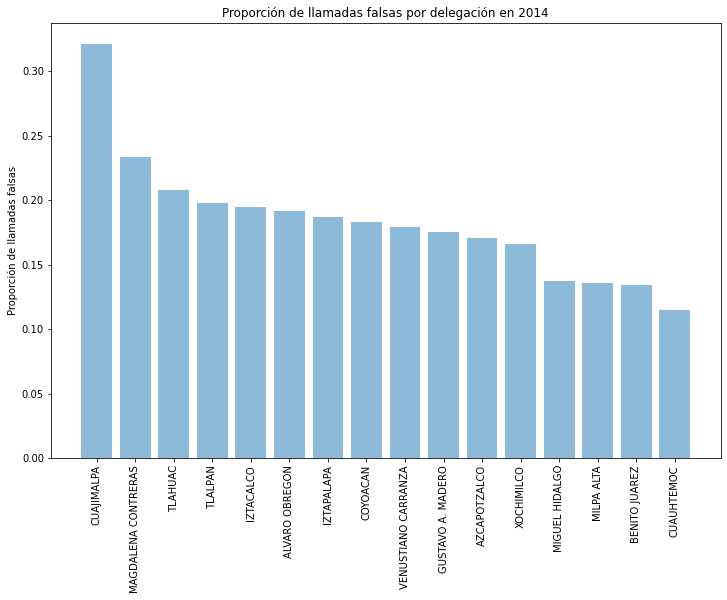

In [50]:
#para 1 año nada más

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(a2014.delegacion_inicio, a2014.label, align='center', alpha=0.5)
plt.ylabel('Proporción de llamadas falsas')
plt.xlabel("")
plt.xticks(rotation=90)
plt.title('Proporción de llamadas falsas por delegación en 2014')
plt.show();

In [51]:
#ahora intentemos el Facet Grid
prop.sort_values(by = ["label", "año_cierre"], ascending = False).head()

,delegacion_inicio,año_cierre,label
65,MAGDALENA CONTRERAS,2016,0.354464
30,CUAJIMALPA,2016,0.345564
33,CUAJIMALPA,2019,0.326004
32,CUAJIMALPA,2018,0.323802
29,CUAJIMALPA,2015,0.323587


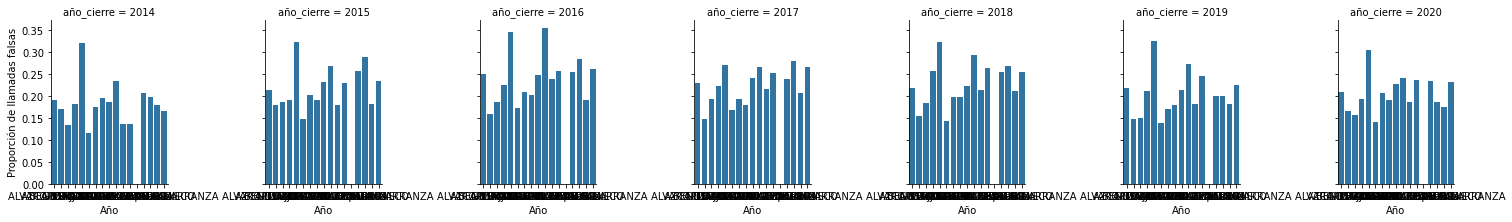

In [115]:
g = sns.FacetGrid(prop, col="año_cierre")
g.map_dataframe(sns.barplot, x="delegacion_inicio", y = "label", data = prop.sort_values(by = ["label"],
                                                                                        ascending = False))
g.set_axis_labels("Año", "Proporción de llamadas falsas")

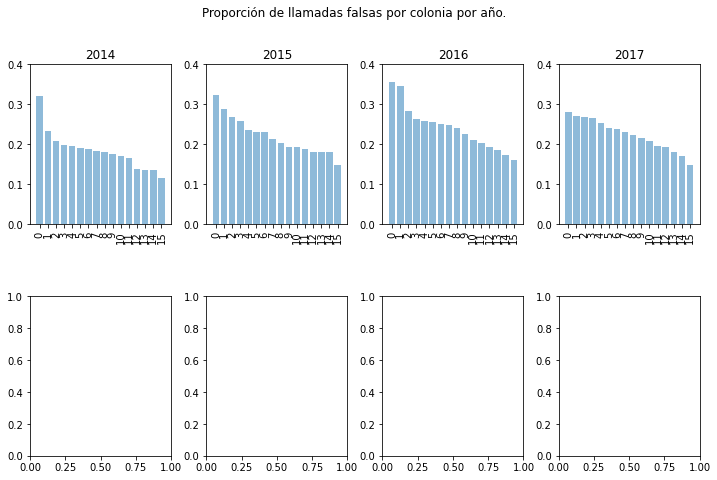

In [134]:
#creo que será mejor hacer el facet frid por mi cuenta 
#paso 1: inicializar el agrupamiento
fig, axs = plt.subplots(2,4, figsize = (12,8))
plt.subplots_adjust(wspace = .25, hspace = .45, bottom = .20)
fig.suptitle('Proporción de llamadas falsas por colonia por año.')
prop_falsas = data.groupby(["delegacion_inicio", "año_cierre"], as_index = False).agg({"label": "mean"})
prop_falsas = prop_falsas[prop_falsas.delegacion_inicio != "No Disponible"]

for i in range(4):
    año = 2014 + i #2014, 2015,..., 2020
    grouping = prop[prop["año_cierre"] == año].sort_values(by = "label", ascending = False)
    axs[0,i].bar(grouping.delegacion_inicio, grouping.label, align='center', alpha=0.5)
    axs[0,i].set_title(f"{str(año)}")
    axs[0,i].set_ylim([0,.40])
    axs[0,i].set_xticks(range(16))
    axs[0,i].set_xticklabels([str(e) for e in range(16)], rotation = 90)

#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
  

#for ax in axs.flat:
#    ax.label_outer()

In [ ]:
#pendiente agregar una gráfica del promedio final! 

#creo que será mejor hacer el facet frid por mi cuenta 
#paso 1: inicializar el agrupamiento
fig, axs = plt.subplots(2,4, figsize = (12,8))
plt.subplots_adjust(wspace = .25, hspace = .15, bottom = .20)
fig.suptitle('Proporción de llamadas falsas por colonia por año.')
prop_falsas = data.groupby(["delegacion_inicio", "año_cierre"], as_index = False).agg({"label": "mean"})
prop_falsas = prop_falsas[prop_falsas.delegacion_inicio != "No Disponible"]

for i in range(7):
    año = 2014 + i #2014, 2015,..., 2020
    grouping = prop[prop["año_cierre"] == año].sort_values(by = "label", ascending = False)
    axs[0,i].bar(grouping.delegacion_inicio, grouping.label, align='center', alpha=0.5)
    axs[0,i].set_title(f"{str(año)}")
    axs[0,i].set_ylim([0,.40])
    axs[0,i].set_xticks(range(16))
    axs[0,i].set_xticklabels([str(e) for e in range(16)], rotation = 90)

#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
  

#for ax in axs.flat:
#    ax.label_outer()

In [133]:
5 % 4

1

In [ ]:
#to do: ver cómo hacer un join en pandas para agregar una columna extra que sea la prop de llamadas
#falsas en esa colonia en ese año 
def add_new_cols(df):
    #df["prop_label"] 
    return df

In [4]:
data.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1


In [5]:
data.año_cierre.value_counts()

2018    246577
2019    229467
2017    226535
2016    190996
2015    184830
2014    171242
2020    133491
Name: año_cierre, dtype: int64

In [6]:
data["label"] = np.where(data["clas_con_f_alarma"] == "FALSA ALARMA", 1, 0)

Primero podemos rápidamente transformar las variables en su tipo de dato adecuado. 

In [7]:
cat_cols = ["dia_semana", "codigo_cierre", "año_cierre", "mes_cierre", "mes", "delegacion_inicio", 
            "incidente_c4", "clas_con_f_alarma", "tipo_entrada", "delegacion_cierre", "hora_creacion",
           "hora_cierre"]

date_cols = ["fecha_creacion", "fecha_cierre"]

In [8]:
def categoric_transformation(col,df):
    df[col] = df[col].astype("category")
    return df 

In [9]:
def fill_na(df):
    """
    Function to fill null values in a dataframe.
    Parameters: pandas dataframe to be transformed
    Returns: transformed dataframe
    """
    df.fillna({'delegacion_inicio': 'No Disponible',
               'delegacion_cierre': 'No Disponible'
              }, inplace = True)
    return df

## ¿Cuáles son los horarios y los días de la semana con más llamadas falsas? 

In [69]:
falsas = data[data.label == 1]
falsas["hora_trunc"] = falsas["hora_creacion"].apply(lambda x: x[:2]).astype(str)
horas_ = {"0:": "00", "0.": "0", "0": "00", "0 ": "00",
          "1:": "01", "2:": "02", "3:": "03", 
          "5:": "05", "6:":"06",
         "7:": "07", "8:": "08", "9:": "09"} #esto puede mejorar 
falsas.hora_trunc.replace(horas_, inplace = True) 
falsas[falsas.hora_trunc == "0"] = falsas[falsas.hora_trunc == "0"].replace({"0": "00"})

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [70]:
falsas = falsas.drop_duplicates()

In [71]:
dia = falsas.groupby(["dia_semana"], as_index = False).agg({"label": "sum"})
dia = dia.rename(columns = {'label': "Total de Llamadas Falsas"})
dia = dia.sort_values(by = "Total de Llamadas Falsas", ascending = False)

In [72]:
dia.head(7)

,dia_semana,Total de Llamadas Falsas
6,Viernes,1853
4,Miércoles,1592
1,Jueves,1586
5,Sábado,1527
3,Martes,1499
2,Lunes,1326
0,Domingo,1247


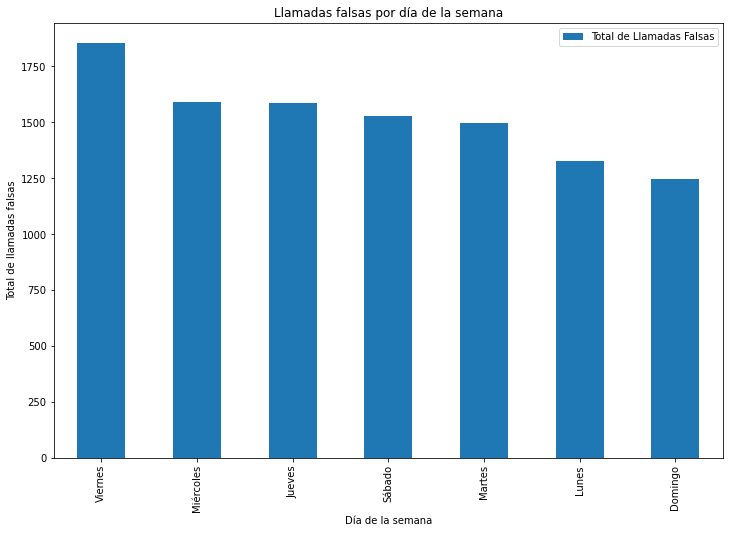

In [73]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = dia.plot.bar(ax=ax, x= "dia_semana")
plt.title("Llamadas falsas por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Total de llamadas falsas")
plt.show();

Podemos notar que la diferencia no es muy grande (aproximadamente 600 llamadas de diferencia entre el viernes y el domingo a lo largo de 6 años) pero sí es lo suficientemente notoria para pensar que hace sentido que en viernes haya más llamadas falsas dado que puede haber grupos de personas que solo quieran divertirse de esa manera. 

#### Veamos qué pasa por hora del día. 

In [74]:
hora = falsas.groupby(["hora_trunc"], as_index = False).agg({"label": "sum"})
hora = hora.rename(columns = {'label': "Total de Llamadas Falsas"})
hora = hora.sort_values(by = "Total de Llamadas Falsas", ascending = False)

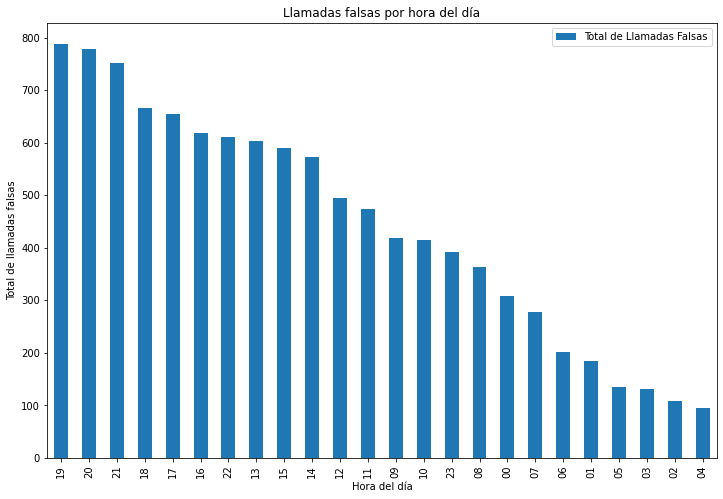

In [75]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = hora.plot.bar(ax=ax, x= "hora_trunc")
plt.title("Llamadas falsas por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Total de llamadas falsas")
plt.show();

Esto está interesante. Podemos notar que claramente hay más llamadas falsas en la noche que ne la madrugada o a horas tempranas del día. Siete, ocho y nueve de la noche son los tres horarios con más llamadas falsas, y después vienen las seis, cinco y cuatro de la tarde. Esto nos da mayor claridad respecto a los patrones de las llamadas falsas. 

También podríamos encontrar las combinación de día-hora donde han ocurrido más llamadas falsas. Dado que son demasiadas combinaciones (24 * 7 = 168), solo voy a mostrar las primeras diez o quince. 

In [76]:
dia_hora = falsas.groupby(["hora_trunc", "dia_semana"], as_index = False)
dia_hora = dia_hora["label"].sum().sort_values(by = "label", ascending = False)
dia_hora = dia_hora.rename(columns = {'label': "Total de Llamadas Falsas"})

In [77]:
dia_hora.head()

,hora_trunc,dia_semana,Total de Llamadas Falsas
153,21,Viernes,166
146,20,Viernes,153
139,19,Viernes,152
160,22,Viernes,130
132,18,Viernes,127


In [78]:
dia_hora.dtypes

hora_trunc                    object
dia_semana                  category
Total de Llamadas Falsas       int64
dtype: object

In [79]:
dia_hora["comb_dia_hora"] = dia_hora["dia_semana"].astype(str) + "  " + \
                            dia_hora["hora_trunc"] + " hrs."

In [80]:
dia_hora.head()

,hora_trunc,dia_semana,Total de Llamadas Falsas,comb_dia_hora
153,21,Viernes,166,Viernes 21 hrs.
146,20,Viernes,153,Viernes 20 hrs.
139,19,Viernes,152,Viernes 19 hrs.
160,22,Viernes,130,Viernes 22 hrs.
132,18,Viernes,127,Viernes 18 hrs.


In [81]:
top_10 = dia_hora.iloc[:10,:].copy()

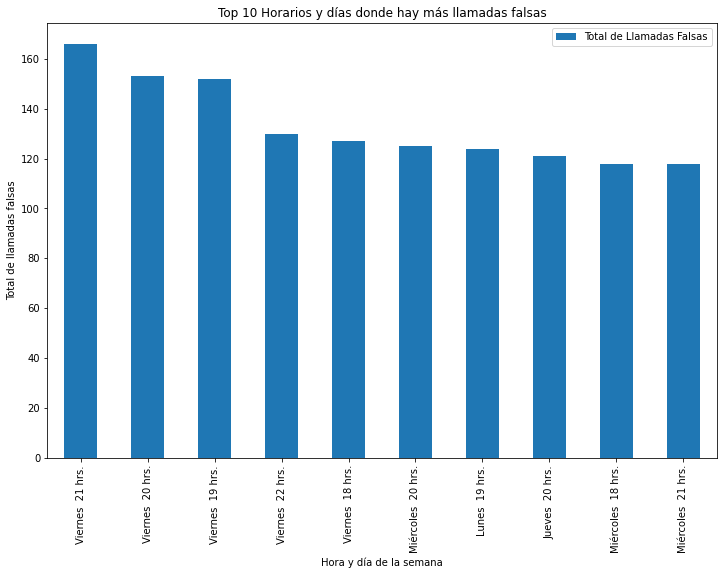

In [82]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = top_20.plot.bar(ax=ax, x= "comb_dia_hora", y= "Total de Llamadas Falsas")
plt.title("Top 10 Horarios y días donde hay más llamadas falsas")
plt.xlabel("Hora y día de la semana")
plt.ylabel("Total de llamadas falsas")
plt.show();

Las primeras cinco ocurrencias son en viernes de 6 a 10 de la noche. Otros 3 lugares le corresponden al miércoles en la noche. 

Sería problemático que a esas horas y en esos días hubiera también muchas llamadas que realmente necesitan atención. 

#### El último análisis (por ahora) puede ser por delegación. 

In [83]:
deleg = falsas.groupby(["delegacion_inicio"], as_index = False).agg({"label": "sum"})
deleg = deleg.rename(columns = {'label': "Total de Llamadas Falsas"})
deleg = deleg.sort_values(by = "Total de Llamadas Falsas", ascending = False)

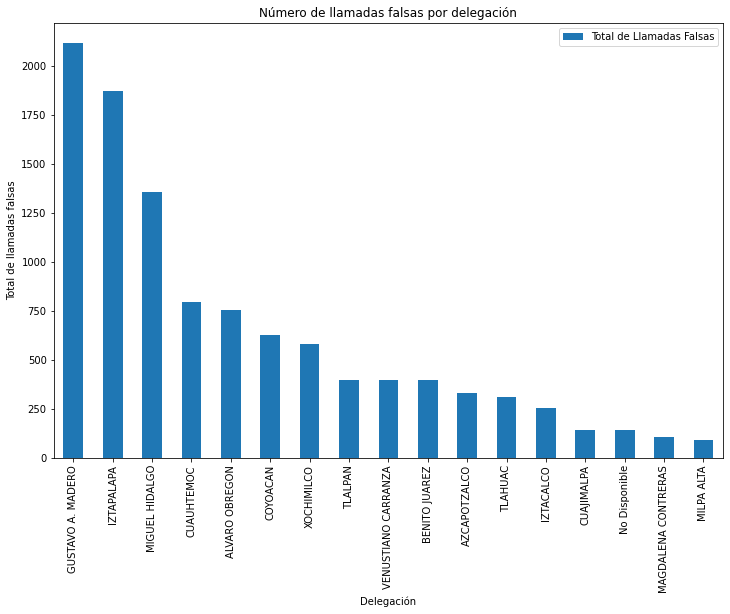

In [84]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = deleg.plot.bar(ax=ax, x= "delegacion_inicio", y= "Total de Llamadas Falsas")
plt.title("Número de llamadas falsas por delegación")
plt.xlabel("Delegación")
plt.ylabel("Total de llamadas falsas")
plt.show();

Estaría interesante ver si estas delegaciones con muchas llamadas falsas también las hacen en viernes etc. 

In [92]:
col_viernes = falsas[falsas.dia_semana == "Viernes"].groupby("delegacion_inicio", as_index = False).agg({"label": "sum"})
col_viernes = col_viernes.sort_values(by="label", ascending = False)
col_viernes = col_viernes.rename(columns = {"label": "Total de Llamadas Falsas"})

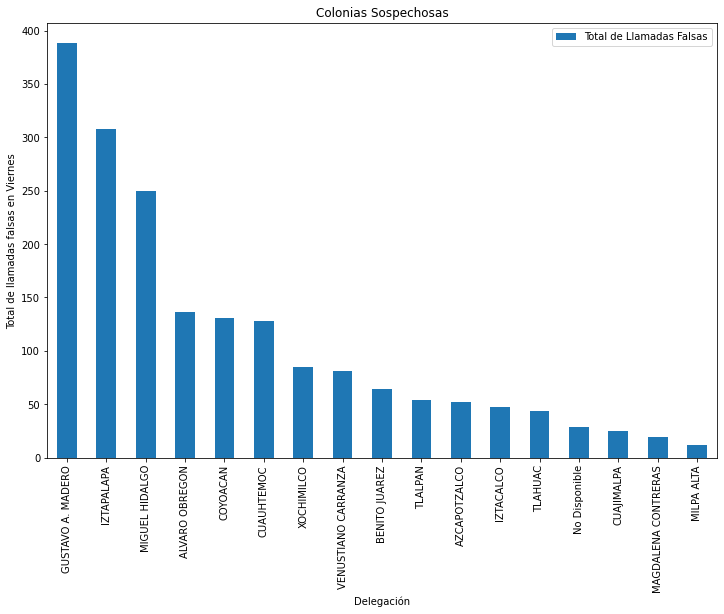

In [95]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = col_viernes.plot.bar(ax=ax, x= "delegacion_inicio", y= "Total de Llamadas Falsas")
plt.title("Colonias Sospechosas")
plt.xlabel("Delegación")
plt.ylabel("Total de llamadas falsas en Viernes")
plt.show();